# Monte Carlo significance testing on time-series data for tendencies

### H0 - Time, like life, has no meaning

Shuffel/resample time series data to build a population of n=1,000 random 5-value draws. This population represents the range of values one would expect from the data if time had no meaning.


### H1 - Earlier values in the time-series are significantly different from later values

Take the first 5-value smooth (t0) – where for annual data, this means a 5-year average– and the last 5-year smooth from the time series (tn). If there is a long-term tendency in the data, the values should be at opposite ends of the H0 distribution. The final significance will be the cumulative p-values of t0 and tn based off the CDF of H0). A symetrical uncertainty for the p-value estimate can be approximated by calculating the standard deviation (sigma) of the means of t0 and tn and using those to bound the mean values (±1 sigma) prior to calculating the p-value. The upper and lower p-values for each t-observation can then be calculated in the same manner as before, and multiplying the p-values of the bounds of the mean will provide a singificance bound for the cumulative probability of the observed ts.

In [1]:
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.stats as stats

In [2]:
%matplotlib inline

In [3]:
table0="035f9d9c-3a3d-4ef2-957b-1764e1c408b4"  ### STAGING API (ADM0) 
table1="b8618a44-2fd7-4461-9178-a05de20027d3"  ### STAGING API (ADM1) 
table2="6c7c2732-b3ca-47c6-a5d4-9f0ae55c19cd"  ### STAGING API (ADM2)

In [4]:
url = "https://staging-api.globalforestwatch.org/v1/"
r = requests.get(url + f'fields/{table0}')
print(f'Status code: {r.status_code}')
pprint(r.json())

Status code: 200
{'fields': {'avg_biomass_per_ha': {'type': 'double'},
            'aze': {'type': 'keyword'},
            'extent_2000': {'type': 'double'},
            'extent_2010': {'type': 'double'},
            'global_land_cover': {'type': 'keyword'},
            'idn_forest_moratorium': {'type': 'keyword'},
            'ifl': {'type': 'keyword'},
            'iso': {'type': 'keyword'},
            'kba': {'type': 'keyword'},
            'land_right': {'type': 'keyword'},
            'landmark': {'type': 'keyword'},
            'managed_forests': {'type': 'keyword'},
            'mining': {'type': 'keyword'},
            'oil_palm': {'type': 'keyword'},
            'plantations': {'type': 'keyword'},
            'primary_forest': {'type': 'keyword'},
            'resource_right': {'type': 'keyword'},
            'tcs': {'type': 'keyword'},
            'threshold': {'type': 'integer'},
            'tiger_cl': {'type': 'keyword'},
            'total_area': {'type': 'double'},
    

In [137]:
iso = 'ESP'
thresh=30

query = (f"""SELECT year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.carbon_emissions) """
         f"""as emissions FROM {table0} WHERE iso = '{iso}' """
         f"""AND threshold = {thresh} GROUP BY nested(year_data.year)""")

        
r = requests.get(url + 'query/', params={'sql': query})

print(r.url)
print(f'Status code: {r.status_code}')
# #pprint(r.json())

https://staging-api.globalforestwatch.org/v1/query/?sql=SELECT+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.carbon_emissions%29+as+emissions+FROM+035f9d9c-3a3d-4ef2-957b-1764e1c408b4+WHERE+iso+%3D+%27ESP%27+AND+threshold+%3D+30+GROUP+BY+nested%28year_data.year%29
Status code: 200


In [138]:
data = r.json()

In [139]:
len(data.get('data'))

18

In [140]:
emissions = {}
for year in data.get('data'):
    emissions[year.get('year')] = year.get('emissions')
emissions

{2001: 8523609.893269539,
 2002: 9219075.336818695,
 2003: 5745394.048210621,
 2004: 16352804.901271343,
 2005: 11950375.210030556,
 2006: 18535092.244664192,
 2007: 15964553.06836462,
 2008: 12015146.018202782,
 2009: 17515508.700252533,
 2010: 14973976.22736454,
 2011: 10555302.132576942,
 2012: 19785808.554305553,
 2013: 15784503.92861414,
 2014: 18598649.662708282,
 2015: 16366608.645088673,
 2016: 26919829.052940845,
 2017: 24389565.014420033,
 2018: 31650039.900456905}

In [141]:
df = pd.DataFrame(list(emissions.values()), index=list(emissions.keys()), columns=['carbon_emissions'])
df.head()

,carbon_emissions
2001,8.523610e+06
2002,9.219075e+06
2003,5.745394e+06
2004,1.635280e+07
2005,1.195038e+07


In [157]:
window = 5

boxcar = df.rolling(window=window, min_periods=window, win_type='boxcar', center=True).mean()

In [179]:
t0_sigma=np.std(df.values[0:window])
tn_sigma=np.std(df.values[-window:])

print(f"Range of uncertaity around t0 = {t0_sigma + t0:1.2g} to {t0 - t0_sigma:1.2g}")
print(f"Range of uncertaity around tn = {tn_sigma + tn:1.2g} to {tn - tn_sigma:1.2g}")

Range of uncertaity around t0 = 1.4e+07 to 6.8e+06
Range of uncertaity around tn = 2.9e+07 to 1.8e+07


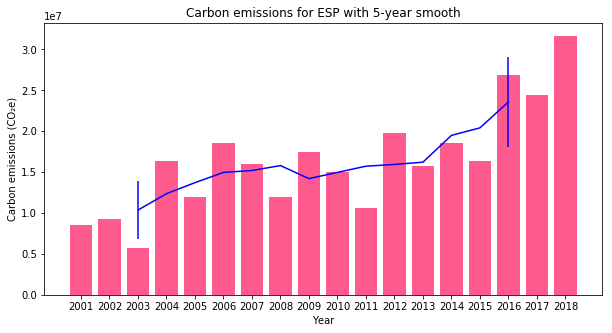

In [187]:
fig=None
fig = plt.figure()
fig.set_size_inches(10,5)
ax1 = fig.add_subplot(111)    

ax1.bar(df.index, df.carbon_emissions, color=['#FE5A8D'])
ax1.set_xticks(df.index)
ax1.set_xlabel('Year')
ax1.set_ylabel('Carbon emissions (CO₂e)')

ax1.plot(boxcar.index, boxcar.carbon_emissions, color='b')
ax1.set_title(f"Carbon emissions for {iso} with {window}-year smooth")

ax1.vlines(2003, t0_sigma + t0, t0 - t0_sigma, color='b')
ax1.vlines(2016, tn_sigma + tn, tn - tn_sigma, color='b')

fig.show()

In [144]:
boxcar_values = boxcar.carbon_emissions.values

mask = np.isnan(boxcar_values)
cleaned_boxcar_values = boxcar_values[mask != True]
t0 = cleaned_boxcar_values[0]
tn = cleaned_boxcar_values[-1]
anomaly = tn - t0
print(f"Tendency over {iso} has been {anomaly} CO₂e during observed period.")

Tendency over ESP has been 13226686.577202797 CO₂e during observed period.


## Build the MC distribution (null-cases)

In [145]:
mc_n = 10000

values = list(df.values.flatten())

mc_pop = []
for draw in range(mc_n):
    tmp_mean1 = np.array(random.choices(population=values, k=window)).mean()
    tmp_mean2 = np.array(random.choices(population=values, k=window)).mean()
    tmp_anom = tmp_mean1 - tmp_mean2
    mc_pop.append(tmp_anom)

<BarContainer object of 100 artists>

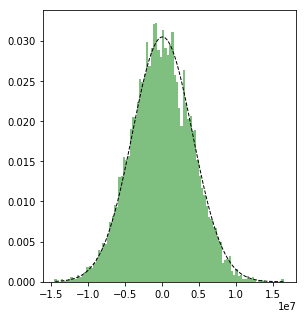

In [146]:
bin_number = 100
hist = np.histogram(mc_pop, bins=bin_number)

bins = hist[1]
density = hist[0] / hist[0].sum()
step = (bins[1] - bins[0])
bcenter = [bpos + step for bpos in bins[:-1]]


# Gauss fit
mu, sigma = np.mean(mc_pop), np.std(mc_pop)
ygauss = stats.norm.pdf(bins, mu, sigma) # a function from matplotlib.mlab.
ynormgauss = ygauss/sum(ygauss) # Normalize distribution so sum is 1.0


# Plot histogram and polynomial function
h0 = plt.figure()
h0.set_size_inches(10, 5)
ax1 = h0.add_subplot(121)

ax1.plot(bins, ynormgauss,'k--',linewidth=1.) # Ideal Gaussian

ax1.bar(hist[1][0:-1], density, width=step, facecolor='g', 
        linewidth=0.0,alpha=0.5)      # Filled bars

In [147]:
def sumarise(observed, mu, sigma):
    """
    For any given r-value (observed), print out the density predicted
    by a Gaussian fit and a polynomial fit, and compare the values.
    The name of the sample, given as a keyword can also be provided.
    """
    norm_density = stats.norm.pdf(observed, mu, sigma)/sum(ygauss)
    print(f"Sample {observed:.2g}: Density of the PDF at the specified anomaly value is {norm_density:4.3f}")
    return

In [220]:

def integrate_fits(anomaly, mu, sigma, iso=iso):
    """
    Use a CDF of the Gaussian distribution to estimate probability.
    """
    cdf_value = stats.norm.cdf(anomaly, mu, sigma)
    p_val = 1 - cdf_value
    if anomaly > 0: 
        change = 'Increase'
    else:
        change = 'Decrease'
    print(f"{iso} {change} of {anomaly:.2g} CO₂e over observation period has an associated p-value of {p_val:3.5f}.")

In [151]:
sumarise(anomaly, mu=mu, sigma=sigma)

integrate_fits(anomaly=anomaly, mu=mu, sigma=sigma)

Sample 1.3e+07: Density of the PDF at the specified anomaly value is 0.000
Increase of 1.3e+07 CO2e over observation period has an associated p-value of 0.00061.


In [221]:
def calc_timeseries_significance(iso, thresh=30, window=5, mc_n=1000, bin_number=100, show_figs=True):
#    iso = 'ESP'

    query = (f"""SELECT year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.carbon_emissions) """
             f"""as emissions FROM {table0} WHERE iso = '{iso}' """
             f"""AND threshold = {thresh} GROUP BY nested(year_data.year)""")
    r = requests.get(url + 'query/', params={'sql': query})
    if r.status_code != 200:
        raise ValueError(f'Failed request {r.status_code}: {r.json()}')
    data = r.json()
    emissions = {}
    for year in data.get('data'):
        emissions[year.get('year')] = year.get('emissions')
    emissions
    df = pd.DataFrame(list(emissions.values()), index=list(emissions.keys()), columns=['carbon_emissions'])
    df.head()
    boxcar = df.rolling(window=window, min_periods=window, win_type='boxcar', center=True).mean()
    t0_sigma=np.std(df.values[0:window])
    tn_sigma=np.std(df.values[-window:])
    boxcar_values = boxcar.carbon_emissions.values
    mask = np.isnan(boxcar_values)
    cleaned_boxcar_values = boxcar_values[mask != True]
    t0 = cleaned_boxcar_values[0]
    tn = cleaned_boxcar_values[-1]
    anomaly = tn - t0
    if show_figs:
        fig=None
        fig = plt.figure()
        fig.set_size_inches(10,5)
        ax1 = fig.add_subplot(111)    
        ax1.bar(df.index, df.carbon_emissions, color=['#FE5A8D'])
        ax1.set_xticks(df.index)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Carbon emissions (CO₂e)')
        ax1.plot(boxcar.index, boxcar.carbon_emissions, color='b')
        ax1.set_title(f"Carbon emissions for {iso} with {window}-year smooth")
        ax1.vlines(2003, t0_sigma + t0, t0 - t0_sigma, color='b')
        ax1.vlines(2016, tn_sigma + tn, tn - tn_sigma, color='b')
        fig.show()

    #print(f"Tendency over {iso} has been {anomaly} CO₂e during observed period.")
    values = list(df.values.flatten())
    mc_pop = []
    for draw in range(mc_n):
        tmp_mean1 = np.array(random.choices(population=values, k=window)).mean()
        tmp_mean2 = np.array(random.choices(population=values, k=window)).mean()
        tmp_anom = tmp_mean1 - tmp_mean2
        mc_pop.append(tmp_anom)
    hist = np.histogram(mc_pop, bins=bin_number)
    bins = hist[1]
    density = hist[0] / hist[0].sum()
    step = (bins[1] - bins[0])
    bcenter = [bpos + step for bpos in bins[:-1]]
    # Gauss fit
    mu, sigma = np.mean(mc_pop), np.std(mc_pop)
    ygauss = stats.norm.pdf(bins, mu, sigma) # a function from matplotlib.mlab.
    ynormgauss = ygauss/sum(ygauss) # Normalize distribution so sum is 1.0

    if show_figs:
        # Plot histogram and polynomial function
        h0 = plt.figure()
        h0.set_size_inches(10, 5)
        ax1 = h0.add_subplot(121)

        ax1.plot(bins, ynormgauss,'k--',linewidth=1.) # Ideal Gaussian

        ax1.bar(hist[1][0:-1], density, width=step, facecolor='g', 
                linewidth=0.0,alpha=0.5)      # Filled bars
        ax1.vlines(anomaly,0, stats.norm.pdf(anomaly, mu, sigma)/sum(ygauss), color='r', linewidth=5.0)
        h0.show()
    #sumarise(anomaly, mu=mu, sigma=sigma)
    integrate_fits(anomaly=anomaly, mu=mu, sigma=sigma, iso=iso)

DEU Increase of 1.6e+06 CO₂e over observation period has an associated p-value of 0.40741.
IDN Increase of 2.8e+08 CO₂e over observation period has an associated p-value of 0.00649.
BRA Increase of 1.8e+07 CO₂e over observation period has an associated p-value of 0.46599.
ARG Decrease of -9.3e+06 CO₂e over observation period has an associated p-value of 0.79261.
ESP Increase of 1.3e+07 CO₂e over observation period has an associated p-value of 0.00029.
FRA Increase of 4e+06 CO₂e over observation period has an associated p-value of 0.20295.


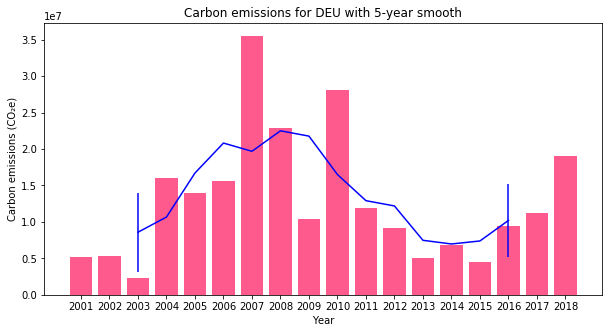

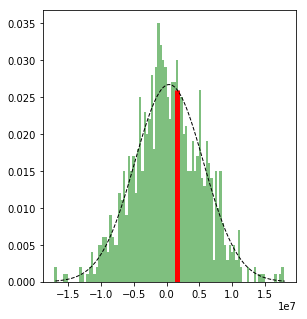

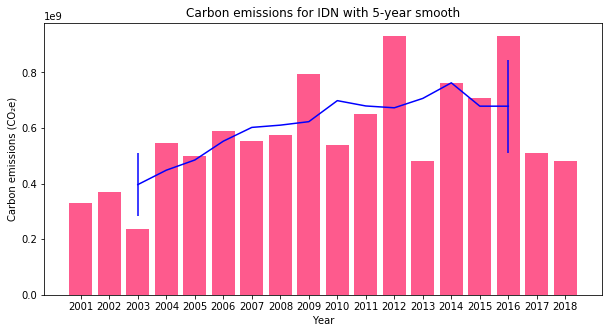

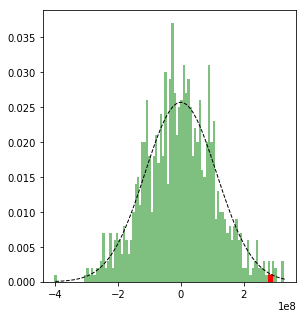

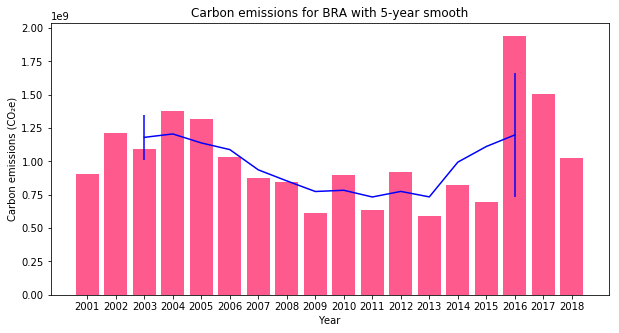

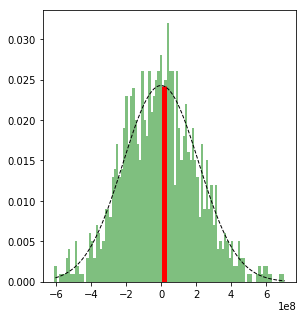

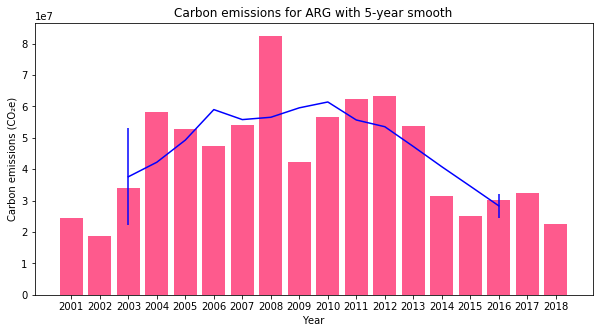

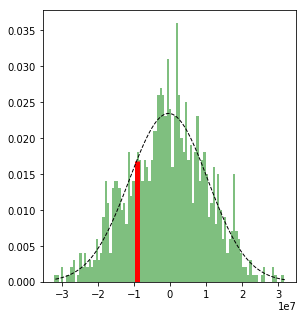

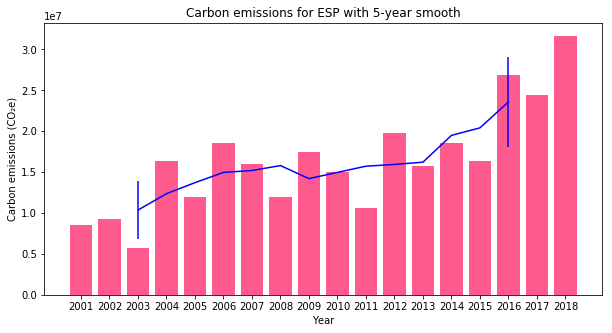

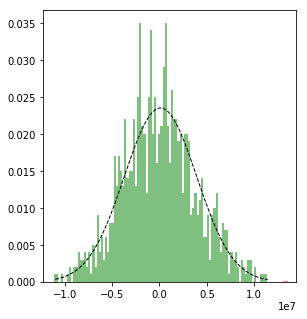

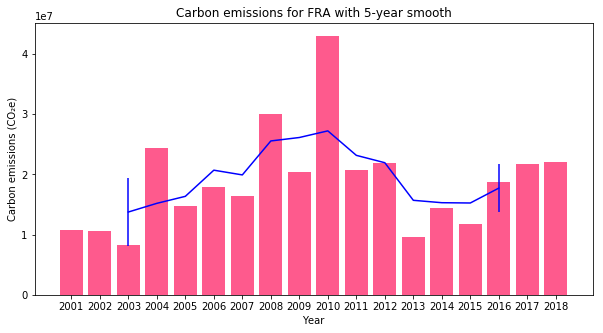

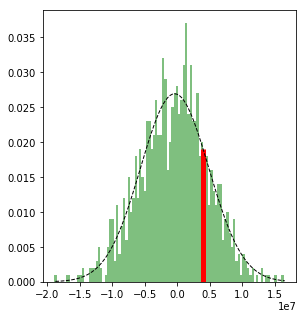

In [223]:
for country in ['DEU', 'IDN', 'BRA', 'ARG', 'ESP','FRA']:
    calc_timeseries_significance(iso=country)